# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
import spacy

In [4]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=226bffe52da7e1129f93eae3a1966f392583a51d05c63487c57e732d004ed44f
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [5]:
from sentence_transformers import SentenceTransformer, util

In [6]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=65e2159c0d1d1ec5ae620737afd7d88050ecbfe3cb59783646ad29233b75078b
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [7]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Preprocessing

In [8]:
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/labels.csv')

In [9]:
labels.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


Loading dataset

In [10]:
labels.shape

(6992, 9)

Mapping the labels ('overall_sentiment'). 'very_positive' and 'positive' will be merged to 1 label, same goes for negative labels.

In [11]:
print(labels['overall_sentiment'].unique())
print(labels['humour'].unique())

labels['overall_sentiment'] = labels['overall_sentiment'].replace({'very_positive':'positive', 'very_negative':'negative'})
labels['humour'] = labels['humour'].replace({'hilarious':1, 'funny':1, 'very_funny':1, 'not_funny':0})

['very_positive' 'positive' 'neutral' 'negative' 'very_negative']
['hilarious' 'not_funny' 'very_funny' 'funny']


In [12]:
labels['offensive'] = labels['offensive'].replace({'very_offensive':1, 'slight':1, 'hateful_offensive':1, 'not_offensive':0})

In [13]:
labels['motivational'] = labels['motivational'].replace({'motivational':1,'not_motivational':0})

In [14]:
labels['sarcasm'] = labels['sarcasm'].replace({'general':1, 'twisted_meaning':1, 'very_twisted':1,'not_sarcastic':0})

In [15]:
labels['sarcasm'].unique()

array([1, 0])

Function preprocessor is used to remove punctuation in the captions and convert the text to lower case.

In [16]:
def preprocessor(text):
    text = re.sub(r'[^\w\s]', '',text)
    text = text.lower()
    return text

Removing rows that have null values (there were not many).

In [17]:
labels = labels.dropna()
labels = labels.reset_index()

In [18]:
for i in range(len(labels)):
    labels['text_corrected'][i] = preprocessor(labels['text_corrected'][i])

<ipython-input-18-c51c6e5353a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['text_corrected'][i] = preprocessor(labels['text_corrected'][i])


Selecting the columns needed (images, captions, and label). 

In [19]:
data_used = labels[['image_name','text_corrected', 'humour', 'sarcasm', 'offensive','motivational', 'overall_sentiment']]

In [20]:
data_used

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,look there my friend lightyear now all sohalik...,1,1,0,0,positive
1,image_2.jpeg,the best of 10 yearchallenge completed in less...,0,1,0,1,positive
2,image_3.JPG,sam thorne strippin follow follow saw everyon...,1,0,0,0,positive
3,image_4.png,10 year challenge sweet dee edition,1,1,1,1,positive
4,image_5.png,10 year challenge with no filter 47 hilarious ...,1,1,1,0,neutral
...,...,...,...,...,...,...,...
6825,image_6988.jpg,tuesday is mardi gras wednesday is valentines ...,1,1,1,1,neutral
6826,image_6989.jpg,must watch movies of 2017 iti chennai memes ma...,1,1,0,0,neutral
6827,image_6990.png,less more talking planning soda junk food comp...,1,1,1,0,positive
6828,image_6991.jpg,when i have time is a fantasy no one has time ...,0,1,0,1,positive


In [21]:
le = LabelEncoder()
data_used['overall_sentiment'] = le.fit_transform(data_used['overall_sentiment'])

<ipython-input-21-648562a388ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['overall_sentiment'] = le.fit_transform(data_used['overall_sentiment'])


Checking the maximum length of captions for padding

In [22]:
lens = []
for i in data_used['text_corrected']:
    lens.append(len(i.split()))
max(lens)

187

# DataLoader

In [23]:
import os
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Using transformer.

In [24]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Function for padding text.

In [25]:
def pad_tensor(t):
    t = torch.tensor(t)
    padding = max(lens) - t.size()[0]
    t = torch.nn.functional.pad(t, (0, padding))
    return t

Load data using custom dataloader class. It returns image int form of tensor, transformed text, and transformed label.

In [26]:
#reference: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/custom_dataset_txt/loader_customtext.py

class MemeSentimentDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None, freq_threshold = 5):
        self.df = csv_file.copy()
        self.img = self.df['image_name']
        self.captions = self.df['text_corrected']
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.root_dir, self.df.iloc[index, 0])).convert("RGB")
        y_label1 = torch.tensor(int(self.df.iloc[index, 2]))
        y_label2 = torch.tensor(int(self.df.iloc[index, 3]))
        y_label3 = torch.tensor(int(self.df.iloc[index, 4]))
        y_label4 = torch.tensor(int(self.df.iloc[index, 5]))
        y_label5 = torch.tensor(int(self.df.iloc[index, 6]))
        caption = self.captions[index]
        if self.transform:
            image = self.transform(image)
         
        padded_text_tensor = pad_tensor(sentence_model.encode(caption, convert_to_tensor=True))
            
        return (image, padded_text_tensor, y_label1, y_label2, y_label3, y_label4, y_label5)

Transforming the read data.

In [27]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]


transform = transforms.Compose(
    [transforms.Resize((100, 100)),  
     transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

In [55]:
dataset = MemeSentimentDataset(csv_file = data_used, root_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/images', transform = transform)

Data split into train and test parts.

In [56]:
train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1830])
train_loader = DataLoader(dataset = train_set, batch_size = 32, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size = 32, shuffle=True)

In [ ]:
# for data in train_loader:
#     image,text,lab1,lab2,lab3,lab4,lab5 =  data
#     print(image.size())

In [ ]:
# for i, data in enumerate(train_loader):
#     i, t, l = data
#     print(t.shape)

# Neural Networks

Neural Networks for images.

In [57]:
class NN(nn.Module):    
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100*100*3, 256),
            nn.ReLU(inplace=False),
            nn.Linear(256, 64),
            nn.ReLU(inplace=False),
            nn.Linear(64, 32),
            nn.ReLU(inplace=False),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Neural Network for text

In [58]:
class NN_text(nn.Module):    
    def __init__(self):
        super(NN_text, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(187, 256),
            nn.ReLU(inplace=False),
            nn.Linear(256, 64),
            nn.ReLU(inplace=False),
            nn.Linear(64, 32),
            nn.ReLU(inplace=False),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Combining both image and text Neural Networks.

In [59]:
class Combined_model(nn.Module):
    def __init__(self, modelA, modelB):
        super(Combined_model, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(6, 128)
        self.classifier1 = nn.Linear(128, 64)
        self.classifier2 = nn.Linear(64, 32)
        self.classifier3 = nn.Linear(32, 16)
        
        self.out1 = nn.Linear(16, 2,)
        self.out2 = nn.Linear(16, 2)
        self.out3 = nn.Linear(16, 2)
        self.out4 = nn.Linear(16, 2)
        self.out5 = nn.Linear(16, 3)

        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(x)
        x = self.classifier1(x)
        x = self.classifier2(x)
        x = self.classifier3(x)
        
        out1 = self.out1(x)
        out2 = self.out2(x)
        out3 = self.out3(x)
        out4 = self.out4(x)
        out5 = self.out5(x)
        return out1, out2, out3, out4, out5

In [60]:
net = NN()
net_text = NN_text()

In [77]:
device = torch.device("cuda")
combined_model.cuda()

Combined_model(
  (modelA): NN(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=30000, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=3, bias=True)
    )
  )
  (modelB): NN_text(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=187, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=3, bias=True)
    )
  )
  (classifier): Linear(in_features=6, out_features=128, bias=True)
  (classifier1): Linear(in_features=128, out_features=64, bias=True)
  (classifi

In [79]:
combined_model = Combined_model(net, net_text).to(device)
torch.save(combined_model.state_dict(), 'combined_model.pt')

In [81]:
image = torch.rand(1,3,100,100).to(device)
text  = torch.rand(1,187).to(device)

In [89]:
out1,out2,out3,out4,out5 = combined_model(image,text)

In [ ]:
# ,out2,out3,out4,out5 = combined_model(image,text)

In [ ]:
# model = Combined_model()

In [ ]:
# toch.save(model.state_dict(), 'combined_model.pt')

Data training and testing. This also shows losses and accuracies after each epoch.

In [84]:
#Reference: AI lab task
def train_loop(dataloader, model, loss_fn1, optimizer1):
    size = len(dataloader.dataset)
    test_loss = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    correct4 = 0
    correct5 = 0
    for batch, (X, T, y1, y2, y3, y4, y5) in enumerate(dataloader):
        # Compute prediction and loss
        pred1, pred2, pred3, pred4, pred5 = model(X,T)
        
        loss1 = loss_fn1(pred1, y1)
        loss1 += loss_fn1(pred2, y2)
        loss1 += loss_fn1(pred3, y3)
        loss1 += loss_fn1(pred4, y4)
        loss1 += loss_fn1(pred5, y5)
        
        # Backpropagation
        with torch.autograd.set_detect_anomaly(True):
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

        if batch % 10 == 0:
            loss1, current = loss1.item(), batch * len(X)
            print(f"loss: {loss1:>7f}  [{current:>5d}/{size:>5d}]")
            

In [85]:

def test_loop(dataloader, model, loss_fn1):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    correct4 = 0
    correct5 = 0

    with torch.no_grad():
        for X, T, y1, y2, y3, y4, y5 in dataloader:
            pred1, pred2, pred3, pred4, pred5 = model(X,T)
            test_loss += loss_fn1(pred1, y1).item()
            test_loss += loss_fn1(pred2, y2).item()
            test_loss += loss_fn1(pred3, y3).item()
            test_loss += loss_fn1(pred4, y4).item()
            test_loss += loss_fn1(pred5, y5).item()
            
            correct1 += (pred1.argmax(1) == y1).type(torch.float).sum().item()
            correct2 += (pred2.argmax(1) == y2).type(torch.float).sum().item()
            correct3 += (pred3.argmax(1) == y3).type(torch.float).sum().item()
            correct4 += (pred4.argmax(1) == y4).type(torch.float).sum().item()
            correct5 += (pred5.argmax(1) == y5).type(torch.float).sum().item()

    test_loss /= num_batches
    correct1 /= size
    correct2 /= size
    correct3 /= size
    correct4 /= size
    correct5 /= size
    
    print(f"\n Humour Accuracy: {(100*correct1):>0.1f}%")
    print(f"\n Sarcasm Accuracy: {(100*correct2):>0.1f}%")
    print(f"\n Offensive Accuracy: {(100*correct3):>0.1f}%")
    print(f"\n Motivational Accuracy: {(100*correct4):>0.1f}%")
    print(f"\n Overall sentiment Accuracy: {(100*correct5):>0.1f}%")

I used Adam optimizer and cross entropy loss.

In [92]:
#model=Combined_model(M1,M2)
loss_fn1 = nn.CrossEntropyLoss().to(device)
optimizer1 = torch.optim.Adam(combined_model.parameters(), lr=0.001)

In [94]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, combined_model, loss_fn1, optimizer1)
    test_loop(test_loader, combined_model, loss_fn1)
print("Done!")

Epoch 1
-------------------------------


<ipython-input-25-03565fe0dd97>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


RuntimeError: ignored

# Visualization

In [ ]:
# !pip install torchviz

In [ ]:
from torchviz import make_dot

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

<ipython-input-24-03565fe0dd97>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


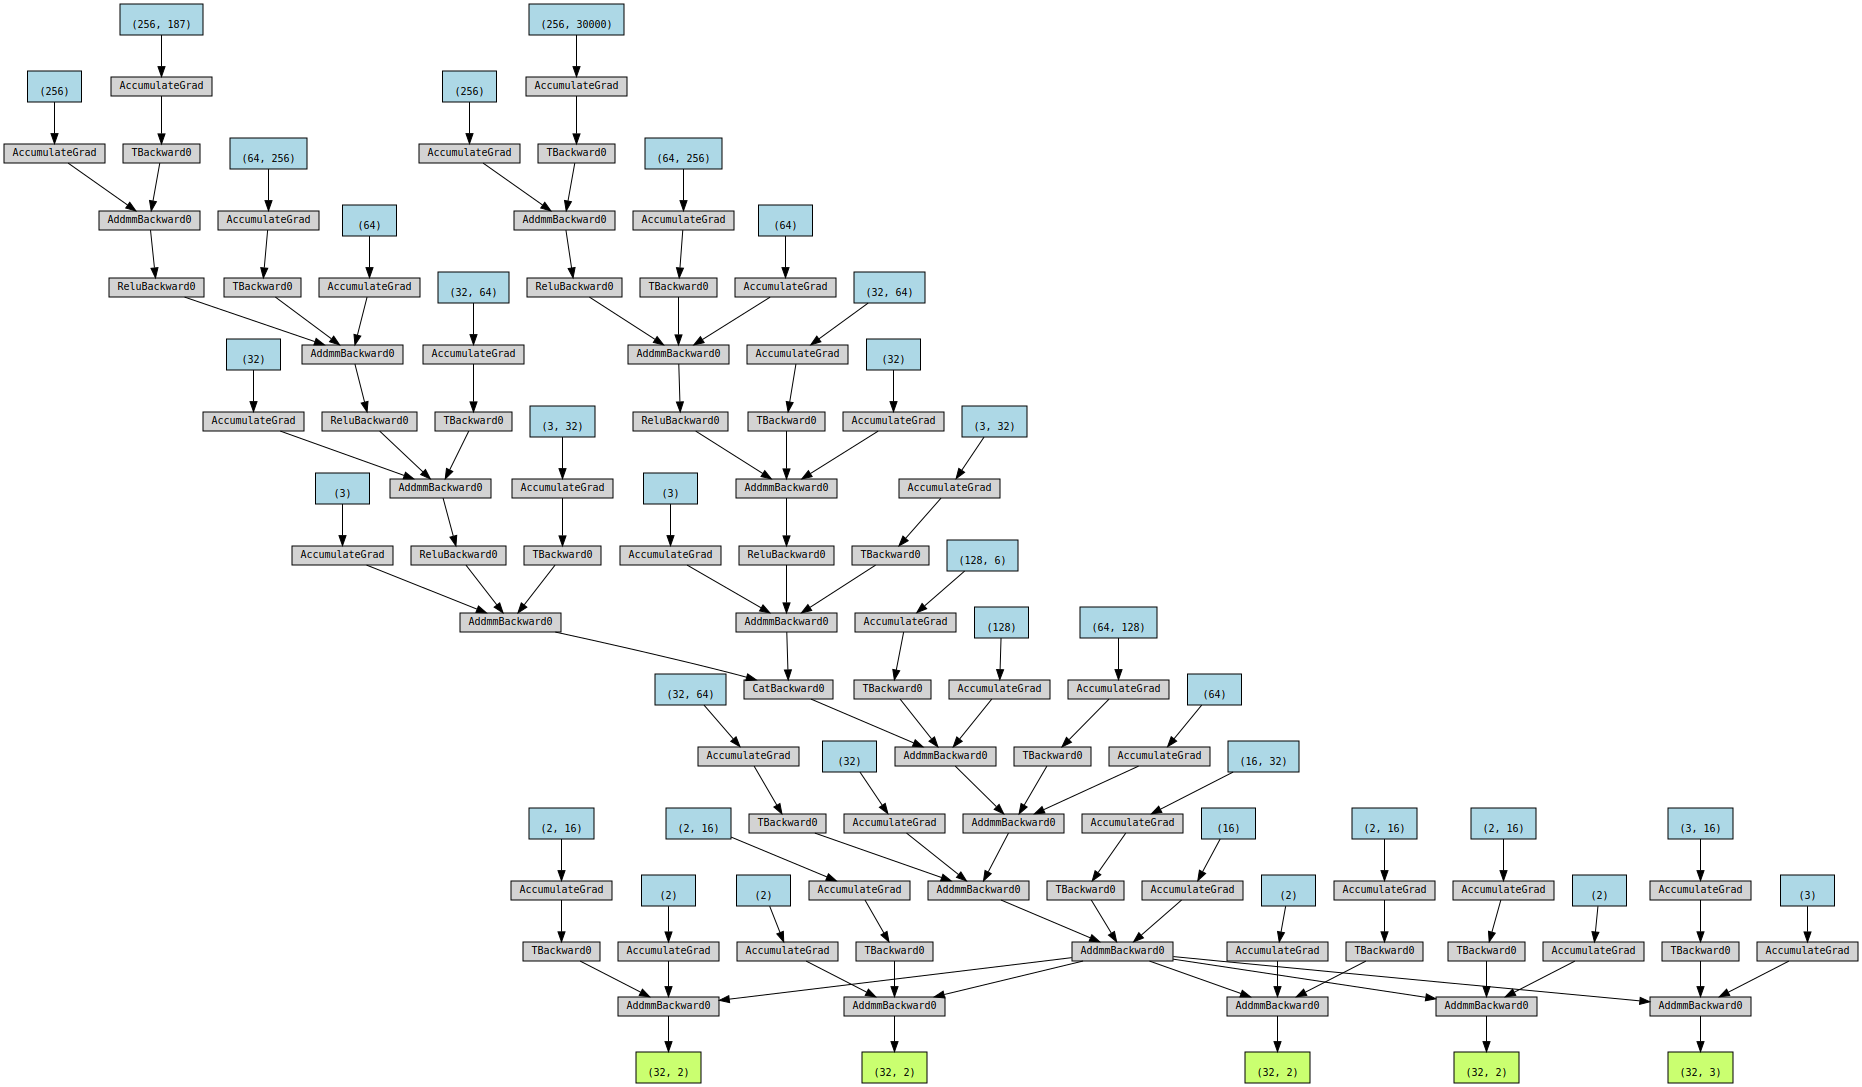

In [ ]:
network = next(iter(train_loader))
graph = combined_model(network[0],network[1])
make_dot(graph)